In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns; sns.set()
np.core.arrayprint._line_width = 160

#### Create two orthonormal vectors, randomly distributed over the dim-sphere

In [2]:
def randomOrthoNormalPair(dim:int) :
    a = np.array(np.random.randn(dim))
    b = np.array(np.random.randn(dim))
    orthoA = b - a * np.dot(a, b) / np.square(np.linalg.norm(a))
    return np.array([a / np.linalg.norm(a), orthoA / np.linalg.norm(orthoA)])

In [3]:
orthoNormalPairs = [randomOrthoNormalPair(3) for i in range(2)]
orthoNormalPairs[0]

array([[-0.44202898,  0.7418999 ,  0.50417747],
       [ 0.01638236, -0.55529944,  0.83148912]])

In [4]:
[(np.dot(a, a), np.dot(b, b), np.dot(a, b)) for a, b in orthoNormalPairs]

[(1.0000000000000002, 1.0, 5.5511151231257827e-17),
 (1.0, 0.99999999999999978, -5.5511151231257827e-17)]

##### Create a diagonal matrix

In [1]:
def diagMagMatrix(dim:int, mag:float):
    return np.matrix(np.diag([mag] * dim))

In [6]:
diagMagMatrix(3, 1.5)

matrix([[ 1.5,  0. ,  0. ],
        [ 0. ,  1.5,  0. ],
        [ 0. ,  0. ,  1.5]])

#### String formatting

In [7]:
def Format2Tuple(tup):
    return "({:.2f}, {:.2f})".format(tup[0], tup[1])

In [8]:
def defaultFormat(tup):
    return str(tup)

### Data types

In [9]:
from collections import namedtuple

In [10]:
D2LatticeOfVectors = namedtuple('D2LatticeOfVectors', 'v1 v2 v1tics v2tics vectors coords')
# A 2d lattice layout of n-dim vectors in n-dim space.
#  v1, v2 : n-dim spanning vectors of the lattice.
#  v1tics, v2tics : lattice line positions along each spanning vector.
#  vectors, coords : the output vectors and their corresponding lattice positions.

In [11]:
TaggedNVectors = namedtuple('TaggedNVectors', 'vectors tags')
# A set of K dim N vectors, with corresponding tags
# vectors: 2d numpy array with shape (K, N)
# tags: numpy array with shape (K)

#### Place 2-D grid points in the plane spanned by two vectors

In [12]:
from collections import namedtuple
def rasterAlongVectors(v2d:D2LatticeOfVectors):
    vectors = np.array([[(v2d.v1*step1 + v2d.v2*step2) 
                         for step2 in v2d.v2tics] 
                         for step1 in v2d.v1tics])
    coords =  np.array([[[step1, step2]
                         for step2 in range(len(v2d.v2tics))] 
                         for step1 in range(len(v2d.v1tics))])
    coords =  coords.reshape(-1, 2)
    coords = [(aa, ba) for [aa, ba] in coords]
    
    return D2LatticeOfVectors(
                v1=v2d.v1,
                v2=v2d.v2,
                v1tics=v2d.v1tics,
                v2tics=v2d.v2tics,
                vectors=np.vstack(vectors),
                coords=coords)

In [13]:
testInput = D2LatticeOfVectors(
              v1=np.array([0, 1, 2]), 
              v2=np.array([.01, .04, .08]), 
              v1tics=np.array([-1, 0, 1]), 
              v2tics=np.array([1, 2, 3]),
              vectors=None,
              coords=None)

result = rasterAlongVectors(testInput)

#### Color mapping

In [14]:
def MakeTagUniqueColorer(tags:list):
    colorMap = {}
    for i, t in enumerate(set(tags)):
        colorMap[t] = i

    palette = sns.color_palette("hls", len(colorMap))
    def fRet(tag):
        return palette[colorMap[tag]]
    return fRet

In [15]:
def RedBlue2dPalette(span_x:int, span_y:int):
    reds = np.linspace(0, 1, span_x)
    blues = np.linspace(0, 1, span_y)
    return [(red, 0, blue) for red in reds for blue in blues]
    #return [np.array([red, 0, blue, 1.]) for red in reds for blue in blues]

In [16]:
def MakeRedBlueGridColorer(span_x:int, span_y:int):
    palette = RedBlue2dPalette(span_x=span_x, span_y=span_y)
    def fRet(tup):
        return palette[span_y * int(tup[0]) + int(tup[1])]
    return fRet

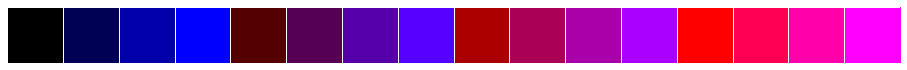

In [17]:
sp = 4
cr = MakeRedBlueGridColorer(span_x=sp, span_y=sp)
clrs = [cr((x, y)) for x in range(sp) for y in range(sp)]
sns.palplot(clrs)

#### Scatterplot of tagged vectors

def PlotTaggedNVectors(tvs:TaggedNVectors, figsize=(4,4), pointSize=10):
    # .. so tags can be mapped to colors for the plot points.
    colorMap = {}
    for i, t in enumerate(set(tvs.tags)):
        colorMap[t] = i
    palette = np.array(sns.color_palette("hls", len(colorMap)))
    colors = np.array([colorMap[t] for t in tvs.tags])

    # We create a scatter plot.
    f = plt.figure(figsize=figsize)
    #ax = plt.subplot(aspect='equal')
    ax = plt.subplot()
    sc = ax.scatter(tvs.vectors[:,0], tvs.vectors[:,1], lw=0, s=pointSize,
                    c=palette[colors])
    # We add the labels for each digit.
    txts = []
    fontSize = 10
    for coord in tvs.tags:
        # Position of each label.
        xtext, ytext = np.median(tvs.vectors[tvs.tags == coord, :2], axis=0)
        txt = ax.text(xtext, ytext, str(coord), fontsize=fontSize)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=0.5 + fontSize/3, foreground=(1,1,1,0)), #, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

In [18]:
def firstLabel(tag_set:set, tag, lblformatter):
    if len(tag_set.intersection({tag})) > 0 :
        tag_set.remove(tag)
        return lblformatter(tag)
    return None

def PlotTaggedNVectors(tvs:TaggedNVectors, colorer=None, lblformatter=defaultFormat, figsize=(4,4), markersize=10, showLegend=False):
    plt.figure(figsize=figsize)
    if colorer==None:
        colorer = MakeTagUniqueColorer(tvs.tags)
    
    fcs = []
    tag_set = set(tvs.tags)
    for i, v in enumerate(tvs.vectors):
        fcs.append(colorer(tvs.tags[i]))
        plt.plot(v[0], v[1], 'o',
         markersize=markersize,
         markerfacecolor=colorer(tvs.tags[i]),
         markeredgewidth=0,
         label=firstLabel(tag_set=tag_set, tag=tvs.tags[i], lblformatter=lblformatter))
    
    minX = np.min(tvs.vectors[:, [0]])
    spanX = np.max(tvs.vectors[:, [0]]) - minX
    if showLegend:
        plt.xlim(minX - spanX * 0.1, minX + spanX * 1.6);
        plt.legend(numpoints=1)
    else:
        plt.xlim(minX - spanX * 0.1, minX + spanX * 1.1);
    return fcs

In [19]:
def PlotTaggedNVectorsGrid(tvs:TaggedNVectors, span_x:int, span_y:int, figsize=(4,4), markersize=10, showLegend=False):
    colorer = MakeRedBlueGridColorer(span_x=span_x, span_y=span_y)
    return PlotTaggedNVectors(tvs=tvs, colorer=colorer, lblformatter=Format2Tuple, figsize=figsize, markersize=markersize, showLegend=showLegend)

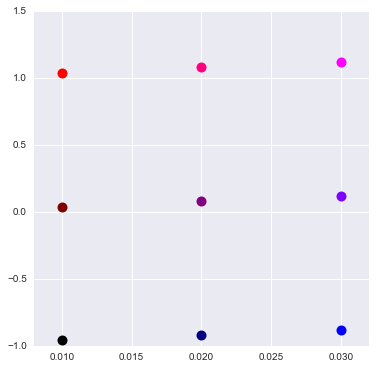

In [20]:
tv = TaggedNVectors(vectors=result.vectors, tags=result.coords)
res = PlotTaggedNVectorsGrid(tvs=tv, span_x=3, span_y=3, figsize=(6,6), markersize=10)

#### Create a 2d lattice of points centered at the origin

In [21]:
def rasterOverCenteredSquare(v1:np.ndarray, v2:np.ndarray, radius:float, stride:int):
    return rasterAlongVectors(
        v2d=D2LatticeOfVectors(
                v1=v1, 
                v2=v2,
                v1tics=np.linspace(-radius, radius, stride),
                v2tics=np.linspace(-radius, radius, stride),
                vectors=None,
                coords=None))

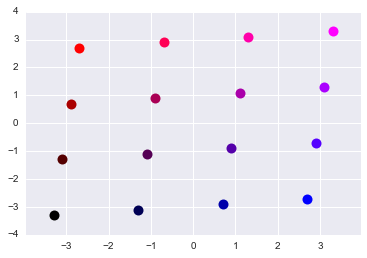

In [22]:
stride = 4
rastOCS = rasterOverCenteredSquare(np.array([0.1, 1.]), np.array([1., 0.1]), radius=3., stride=stride)
tvc = TaggedNVectors(vectors=rastOCS.vectors, tags=rastOCS.coords)
r = PlotTaggedNVectorsGrid(tvc, span_x=stride, span_y=stride, figsize=(6, 4), markersize=10)

#### Create a set of uniform gaussians around each of the provided vectors

In [23]:
def drawAroundVecs(tvs:TaggedNVectors, blobStdev:float=1., pointsPerBlob:int=10):
    blobVecs = tvs.vectors
    blobTags = tvs.tags
    dim = len(blobVecs[0])
    return TaggedNVectors(
        vectors = np.vstack(np.array([np.random.multivariate_normal(blobVecs[i], diagMatrix(dim, blobStdev), pointsPerBlob) 
                              for i in range(len(blobVecs))])),
       tags = [i for i in blobTags for a in range(pointsPerBlob)]
    )

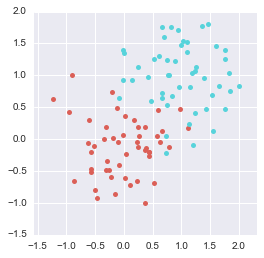

In [24]:
testCenters = TaggedNVectors(vectors=np.array([[0,0], [1,1]]), tags=[(0,1), (1,1)])
blobs = drawAroundVecs(tvs=testCenters, blobStdev=0.25, pointsPerBlob=50)

rr = PlotTaggedNVectors(tvs=blobs, markersize=5)

#### Create a 2d lattice of gaussians in the plane specified by the two input vectors.

In [25]:
def d2LatticeOfGaussians(v1:np.ndarray, v2:np.ndarray, arrayRadius:float, stride:int, blobStdev:float=1., pointsPerBlob:int=10):
    d2Lattice = rasterOverCenteredSquare(v1=v1, v2=v2, radius=arrayRadius, stride=stride)
    return drawAroundVecs(tvs=TaggedNVectors(vectors=d2Lattice.vectors, tags=d2Lattice.coords), 
                          blobStdev=blobStdev, 
                          pointsPerBlob=pointsPerBlob)

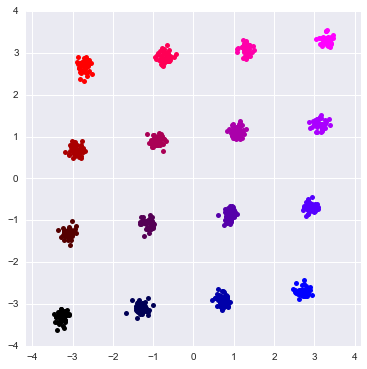

In [26]:
blobStride = 4
blobsL = d2LatticeOfGaussians(v1=np.array([0.1, 1.]), 
                          v2=np.array([1., 0.1]), 
                          arrayRadius=3, 
                          stride=blobStride, 
                          blobStdev=0.01, 
                          pointsPerBlob=50)
r4 = PlotTaggedNVectorsGrid(blobsL, span_x=blobStride, span_y=blobStride, figsize=(6,6), markersize=5)

#### Samples from the N dimensional symmetric gaussian.

In [27]:
dim = 5
count = 10
mean = [np.random.randn() for i in range(dim)]
np.random.multivariate_normal(mean, diagMatrix(dim, 1), count)

array([[ 1.73847268,  1.41072298,  0.34456069,  1.00913   , -0.27580269],
       [-0.74961051,  0.23163725, -0.60367083,  0.85168562,  0.5419866 ],
       [-0.96787058, -0.30247627,  0.57090322, -0.81856157, -0.91831254],
       [-0.24793192,  1.40024859, -1.32190625, -1.14537255, -0.90005971],
       [ 0.20836819,  1.52575492,  0.54212483, -1.85070781,  0.21703437],
       [-0.26530886,  0.31781718, -0.4405511 , -0.09043033, -0.13392132],
       [-2.070197  , -1.40023838, -2.00367027, -1.43193004, -1.61604876],
       [ 1.56426169, -0.19706069, -1.83292181, -0.68848662, -0.61674944],
       [ 0.39777839,  1.1677804 , -0.45261645, -2.54447238, -0.13557731],
       [-0.10848141,  1.01080478,  0.47641185, -1.44481919,  0.7072602 ]])

### Some 2-D multivariate_normal, plotting with matplotlib.plot

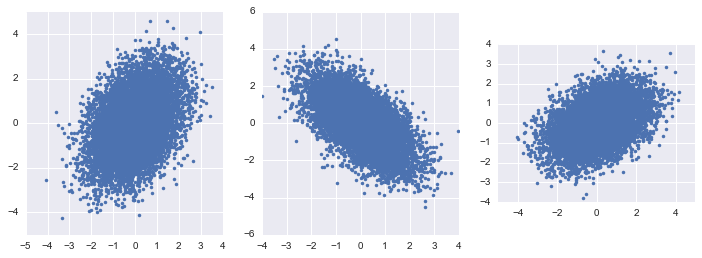

In [28]:
plt.figure(figsize=(12, 4))

samples = np.random.multivariate_normal([0, 0], [[1.0, 0.5],[0.5, 1.5]], 10000)
plt.subplot(1, 3, 1)
plt.plot(samples[:, 0], samples[:, 1], '.')


samples = np.random.multivariate_normal([0, 0], [[1.0, -0.75],[-0.75, 1.5]], 10000)
plt.subplot(1, 3, 2)
plt.plot(samples[:, 0], samples[:, 1], '.')


samples = np.random.multivariate_normal([0, 0], [[1.0, 0.0],[1.0, 1.0]], 10000)
plt.subplot(1, 3, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(samples[:, 0], samples[:, 1], '.')

plt.show()

### Some 2-D multivariate_normal, plotting with matplotlib.scatter

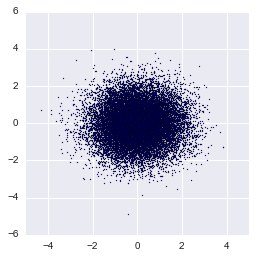

In [29]:
samples = np.random.multivariate_normal([0, 0, 0], [[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]], 20000)
# samples = np.random.multivariate_normal([0, 0, 0], np.matrix.i  20000)
plt.figure(figsize=(4,4))
plt.scatter(samples[:, 0], samples[:, 1], c='b', s=1, label='the data')
plt.show()

In [30]:
import sklearn
from sklearn.manifold import TSNE

In [31]:
gbStride = 3
gridBlobs = d2LatticeOfGaussians(v1=np.array([0.1, 1.]), 
                          v2=np.array([1., 0.1]), 
                          arrayRadius=3, 
                          stride=gbStride, 
                          blobStdev=0.05, 
                          pointsPerBlob=50)

RS = 98154190
grid_proj = TSNE(n_components=2, random_state=RS, init='random').fit_transform(gridBlobs.vectors)

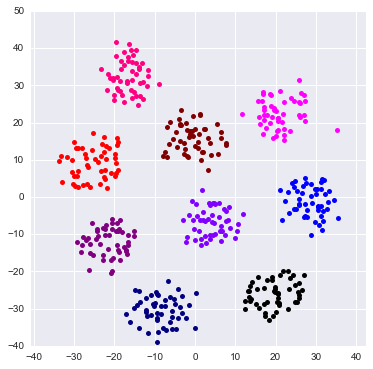

In [32]:
tsnu = TaggedNVectors(vectors=grid_proj, tags=gridBlobs.tags)
r77 = PlotTaggedNVectorsGrid(tsnu, span_x=gbStride, span_y=gbStride, figsize=(6,6), markersize=5)

In [62]:
gbStride22 = 15
orths22 = randomOrthoNormalPair(2)
gridBlobs22 = d2LatticeOfGaussians(v1=orths22[0],
                          v2=orths22[1],
                          arrayRadius=gbStride22,
                          stride=gbStride22,
                          blobStdev=1.,
                          pointsPerBlob=35)

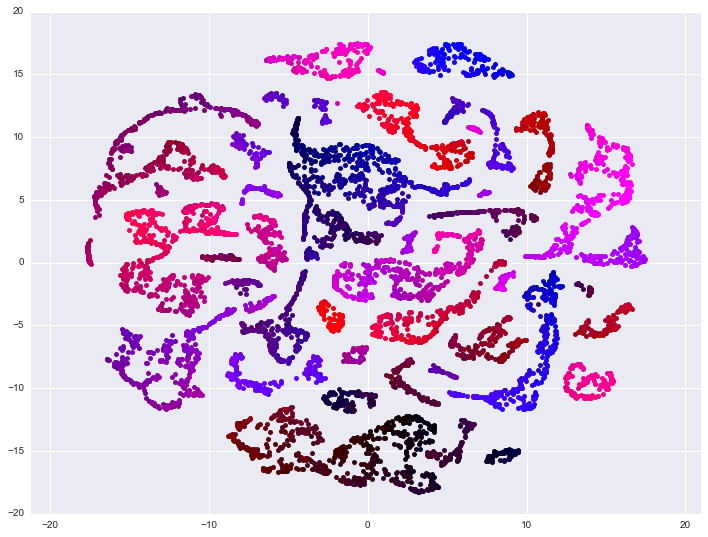

In [63]:
RS = 95154190
grid_proj22 = TSNE(n_components=2, random_state=RS, init='random', learning_rate=2500).fit_transform(gridBlobs22.vectors)
tsnu22 = TaggedNVectors(vectors=grid_proj22, tags=gridBlobs22.tags)
r22 = PlotTaggedNVectorsGrid(tsnu22, span_x=gbStride22, span_y=gbStride22, figsize=(12, 9), markersize=5)

In [36]:
# np.random.multivariate_normal(blobVecs[i], diagMatrix(dim, blobStdev), pointsPerBlob) 

In [71]:
gbHDStride = 15
orths = randomOrthoNormalPair(625)
gridBlobsHD = d2LatticeOfGaussians(v1=orths[0],
                          v2=orths[1],
                          arrayRadius=gbHDStride,
                          stride=gbHDStride,
                          blobStdev=0.095,
                          pointsPerBlob=35)

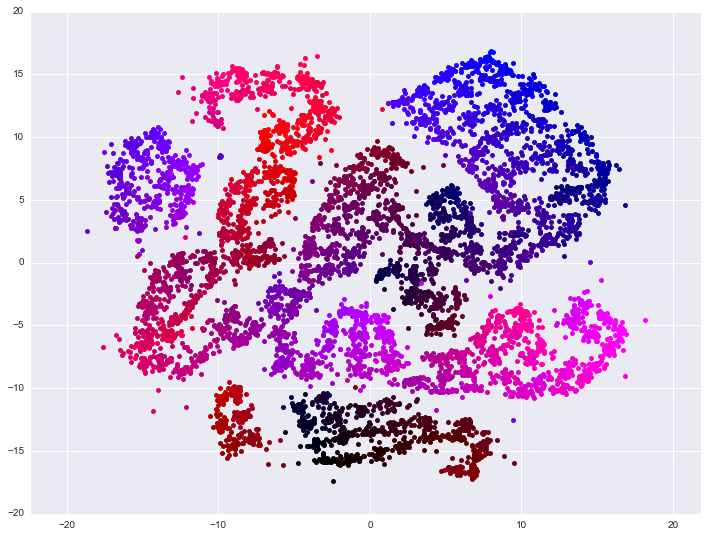

In [79]:
RS = 95154190
grid_projHD = TSNE(n_components=2, random_state=RS, init='random', learning_rate=2500).fit_transform(gridBlobsHD.vectors)

tsnuHD = TaggedNVectors(vectors=grid_projHD, tags=gridBlobsHD.tags)
r55 = PlotTaggedNVectorsGrid(tsnuHD, span_x=gbHDStride, span_y=gbHDStride, figsize=(12, 9), markersize=5)

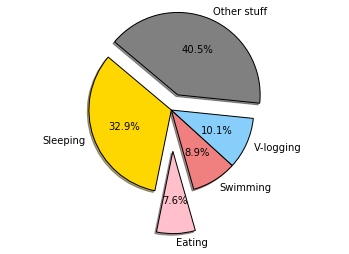

In [3]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Sleeping', 'Eating', 'Swimming', 'V-logging', 'Other stuff'
sizes = [650, 150, 175, 200, 800]
colors = ['gold', 'pink', 'lightcoral', 'lightskyblue', 'gray']
explode = (0, 0.5, 0, 0, 0.2)  # explode last slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()